In [104]:
import os
import pandas as pd
import zipfile
import numpy as np
import xgboost as xgb
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
os.environ['KAGGLE_USERNAME'] = "shirshovml"
os.environ['KAGGLE_KEY'] = "0e76e11b97b72eb66ade50e79e2f233b"
# проходим аутентификацию для kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [4]:
# загружаем датасет 
# Подробное описание - https://www.kaggle.com/datasets/mateusdmachado/csgo-professional-matches
api.dataset_download_files('mateusdmachado/csgo-professional-matches')

In [6]:
with zipfile.ZipFile("csgo-professional-matches.zip", 'r') as zip_ref:
    zip_ref.extractall("datasets")

In [39]:
results = pd.read_csv("datasets/results.csv")
results

,date,team_1,team_2,_map,result_1,result_2,map_winner,starting_ct,ct_1,t_2,t_1,ct_2,event_id,match_id,rank_1,rank_2,map_wins_1,map_wins_2,match_winner
0,2020-03-18,Recon 5,TeamOne,Dust2,0,16,2,2,0,1,0,15,5151,2340454,62,63,0,2,2
1,2020-03-18,Recon 5,TeamOne,Inferno,13,16,2,2,8,6,5,10,5151,2340454,62,63,0,2,2
2,2020-03-18,New England Whalers,Station7,Inferno,12,16,2,1,9,6,3,10,5243,2340461,140,118,12,16,2
3,2020-03-18,Rugratz,Bad News Bears,Inferno,7,16,2,2,0,8,7,8,5151,2340453,61,38,0,2,2
4,2020-03-18,Rugratz,Bad News Bears,Vertigo,8,16,2,2,4,5,4,11,5151,2340453,61,38,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45768,2015-11-05,G2,E-frag.net,Inferno,13,16,2,1,8,7,5,9,1970,2299059,7,16,1,2,2
45769,2015-11-05,G2,E-frag.net,Dust2,16,13,1,1,10,5,6,8,1970,2299059,7,16,1,2,2
45770,2015-11-04,CLG,Liquid,Inferno,16,12,1,1,7,8,9,4,1934,2299011,10,14,16,12,1
45771,2015-11-03,NiP,Dignitas,Train,16,4,1,2,4,1,12,3,1934,2299001,6,12,16,4,1


In [40]:
economy = pd.read_csv("datasets/economy.csv")
economy

C:\Users\anshm\AppData\Local\Temp\ipykernel_8128\1361059185.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  economy = pd.read_csv("datasets/economy.csv")


,date,match_id,event_id,team_1,team_2,best_of,_map,t1_start,t2_start,1_t1,...,21_winner,22_winner,23_winner,24_winner,25_winner,26_winner,27_winner,28_winner,29_winner,30_winner
0,2020-03-01,2339402,4901,G2,Natus Vincere,5,Nuke,t,ct,4350.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-01,2339402,4901,G2,Natus Vincere,5,Dust2,ct,t,3900.0,...,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,NaN
2,2020-03-01,2339402,4901,G2,Natus Vincere,5,Mirage,t,ct,4150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-29,2339401,4901,Natus Vincere,Astralis,3,Dust2,t,ct,4150.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-29,2339401,4901,Natus Vincere,Astralis,3,Nuke,ct,t,4200.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43229,2017-04-04,2309263,2683,FaZe,HellRaisers,1,Cache,t,ct,4250.0,...,2.0,1.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN
43230,2017-04-04,2309262,2683,Astralis,CLG,1,Train,t,ct,4250.0,...,1.0,1.0,1.0,2.0,1.0,1.0,1.0,NaN,NaN,NaN
43231,2017-04-04,2309261,2683,SK,TYLOO,1,Mirage,ct,t,4350.0,...,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,NaN,NaN
43232,2017-04-04,2309260,2683,Virtus.pro,MVP Project,1,Mirage,t,ct,4150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# Производим слияние датасетов по ID матча и Карте (так как у разных карт чаще всего один ID матча)
merged_df = pd.merge(economy, results, how='left', left_on=['match_id', '_map'], right_on=['match_id', '_map'])
# Удаляем дублирующиеся колонки
merged_df.drop(merged_df.filter(regex='_y$').columns, axis=1, inplace=True)
# Убираем суффиксы у колонок, которые дублировались
merged_df.rename(columns=lambda x: x[:-2] if x.endswith('_x') else x, inplace=True)
merged_df.drop(merged_df[merged_df['map_winner'].isnull()].index, inplace=True)
merged_df.drop(merged_df[merged_df['match_winner'].isnull()].index, inplace=True)
merged_df

,date,match_id,event_id,team_1,team_2,best_of,_map,t1_start,t2_start,1_t1,...,starting_ct,ct_1,t_2,t_1,ct_2,rank_1,rank_2,map_wins_1,map_wins_2,match_winner
0,2020-03-01,2339402,4901,G2,Natus Vincere,5,Nuke,t,ct,4350.0,...,2.0,3.0,2.0,1.0,14.0,8.0,6.0,0.0,3.0,2.0
1,2020-03-01,2339402,4901,G2,Natus Vincere,5,Dust2,ct,t,3900.0,...,1.0,7.0,8.0,6.0,8.0,8.0,6.0,0.0,3.0,2.0
2,2020-03-01,2339402,4901,G2,Natus Vincere,5,Mirage,t,ct,4150.0,...,2.0,1.0,2.0,1.0,14.0,8.0,6.0,0.0,3.0,2.0
3,2020-02-29,2339401,4901,Natus Vincere,Astralis,3,Dust2,t,ct,4150.0,...,2.0,2.0,4.0,14.0,1.0,6.0,1.0,2.0,0.0,1.0
4,2020-02-29,2339401,4901,Natus Vincere,Astralis,3,Nuke,ct,t,4200.0,...,1.0,13.0,2.0,3.0,3.0,6.0,1.0,2.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43229,2017-04-04,2309263,2683,FaZe,HellRaisers,1,Cache,t,ct,4250.0,...,2.0,4.0,7.0,6.0,9.0,4.0,15.0,10.0,16.0,2.0
43230,2017-04-04,2309262,2683,Astralis,CLG,1,Train,t,ct,4250.0,...,2.0,10.0,2.0,6.0,9.0,1.0,24.0,16.0,11.0,1.0
43231,2017-04-04,2309261,2683,SK,TYLOO,1,Mirage,ct,t,4350.0,...,1.0,7.0,8.0,9.0,4.0,3.0,33.0,16.0,12.0,1.0
43232,2017-04-04,2309260,2683,Virtus.pro,MVP Project,1,Mirage,t,ct,4150.0,...,2.0,5.0,0.0,11.0,4.0,2.0,98.0,16.0,4.0,1.0


In [46]:
# Проведем исследование на предмет вероятности победы/поражения команды на карте при двух выигранных/проигранных
# пистолетных раундах.

# Возьмем исход первого и второго пистолетных раундов
pistol_1 = merged_df['1_winner']
pistol_2 = merged_df['16_winner']
# Карты на которых они были сыграны
maps = merged_df['_map']
# И результат матча(карты)
winners = merged_df['map_winner']


In [47]:
df = pd.DataFrame()

In [48]:
df['pistol_1'] = pistol_1
df['pistol_2'] = pistol_2
df['winners'] = winners
df['_map'] = maps

In [49]:
# Чтобы оценить сбалансированность набора данных выясним сколько раз была сыграна каждая карта
df['_map'].value_counts()

Mirage         6273
Inferno        6203
Train          4583
Overpass       3966
Nuke           3237
Dust2          2754
Cache          2651
Cobblestone    1477
Vertigo         555
Default          11
Name: _map, dtype: int64

In [50]:
# Уберем все записи со значением Default (карта отсутствует), а также карты которых было сыграно слишком мало
df.drop(df[df['_map'] == 'Default'].index, inplace=True)
df.drop(df[df['_map'] == 'Vertigo'].index, inplace=True)
df.drop(df[df['_map'] == 'Cobblestone'].index, inplace=True)
df['_map'].value_counts()

Mirage      6273
Inferno     6203
Train       4583
Overpass    3966
Nuke        3237
Dust2       2754
Cache       2651
Name: _map, dtype: int64

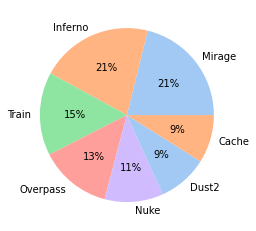

In [51]:
# Построим круговую диаграмму
colors = sns.color_palette('pastel')[0:5]
maps_count = df['_map'].value_counts()
labels = list(maps_count.index)
plt.pie(df['_map'].value_counts(), labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

[3138, 3087, 2305, 1981, 1661, 1389, 1383]
[2179, 2141, 1616, 1380, 1136, 959, 920]
[0.69, 0.69, 0.7, 0.7, 0.68, 0.69, 0.67]
[0.69, 0.69, 0.7, 0.7, 0.68, 0.69, 0.67]


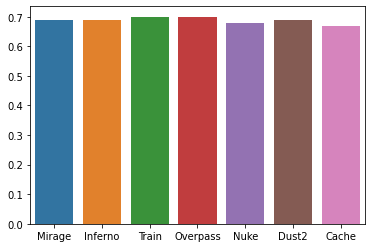

In [53]:
# Оценим насколько победа в обоих пистолетных раундах влияет на победу в матче
# Подсчитаем кол-во матчей на каждой карте, где оба раунда выигрывает одна команда и является победителем по итогу
# Выиграны оба раунда
both_pistols_won = list(
    df[df['pistol_1'] == df['pistol_2']]['_map'].value_counts()
)
print(both_pistols_won)
# Выиграны оба раунда и карта
maps_count_eq_win = list(
    df[(df['pistol_1'] == df['pistol_2']) & (df['pistol_1'] == df['winners'])]['_map'].value_counts()
)
print(maps_count_eq_win)
# Найдем процент таких случаев относительно всех матчей, где выиграны оба раунда
maps_count_norm_win = [
    (lambda i, x: round(x/both_pistols_won[i], 2))(idx, _map) for idx, _map in enumerate(maps_count_eq_win)
]
print(maps_count_norm_win)
# Построим график
ax = sns.barplot(
    x=list(maps_count.index),
    y=maps_count_norm_win,
)
print(maps_count_norm_win)
plt.show()

In [1]:
# Таким образом команды, выигравшие оба пистолетных раунда, в 70% случаев выигрывали карту
# Теперь сделаем оценку важности параметров, выясним какие раунды наиболее влияют на победу в матче, помимо пистолетных

In [118]:
# Функции, которые в дальнейшем понадобятся
def plot_features_scores(model, data, target, column_names, model_type, ): #batch_pos, batch_size
    '''Функция для визуализации важности признаков'''
    
    model.fit(data, target)
    
    if model_type == 'rf':
        (pd.DataFrame(data={'score': model['rf'].feature_importances_},  #[batch_pos:batch_pos+batch_size]
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(20,20), legend=False));
    elif model_type == 'lr':
        (pd.DataFrame(data={'score': model['lr'].coef_[0]},
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(20,20), legend=False));
        
    else:
        raise KeyError('Unknown model_type')

def grid_search(model, gs_params):
    '''Функция для подбора гиперпараметров с помощью перекрёстной проверки'''
     
    gs = GridSearchCV(estimator=model, param_grid=gs_params, refit=True,
                      scoring='roc_auc', n_jobs=-1, cv=skf, verbose=0)
    gs.fit(X, y)
    scores = [gs.cv_results_[f'split{i}_test_score'][gs.best_index_] for i in range(5)]
    print('scores = {}, \nmean score = {:.5f} +/- {:.5f} \
           \nbest params = {}'.format(scores,
                                      gs.cv_results_['mean_test_score'][gs.best_index_],
                                      gs.cv_results_['std_test_score'][gs.best_index_],
                                      gs.best_params_))
    return gs

In [83]:
# Уберем карты с малым количеством матчей
merged_df.drop(merged_df[merged_df['_map'] == 'Default'].index, inplace=True)
merged_df.drop(merged_df[merged_df['_map'] == 'Vertigo'].index, inplace=True)
merged_df.drop(merged_df[merged_df['_map'] == 'Cobblestone'].index, inplace=True)

In [129]:
X = merged_df.loc[:, '_map':'30_winner']
X['rank_1'], X['rank_2'] = merged_df['rank_1'], merged_df['rank_2']
X = X.fillna(-1)
y = merged_df['map_winner']
print(X.head())
y

     _map t1_start t2_start    1_t1     2_t1     3_t1     4_t1     5_t1  \
0    Nuke        t       ct  4350.0   1100.0  22100.0   9350.0  25750.0   
1   Dust2       ct        t  3900.0   7400.0  23250.0  28500.0  31900.0   
2  Mirage        t       ct  4150.0  14300.0   2000.0  24800.0   9000.0   
3   Dust2        t       ct  4150.0  18050.0  21000.0  25850.0  25000.0   
4    Nuke       ct        t  4200.0  10000.0  22000.0  24500.0  27550.0   

      6_t1     7_t1  ...  23_winner  24_winner  25_winner  26_winner  \
0  10400.0  24600.0  ...       -1.0       -1.0       -1.0       -1.0   
1  31700.0  18950.0  ...        1.0        1.0        1.0        1.0   
2  23150.0  21850.0  ...       -1.0       -1.0       -1.0       -1.0   
3  25000.0  27250.0  ...       -1.0       -1.0       -1.0       -1.0   
4  29350.0  31950.0  ...       -1.0       -1.0       -1.0       -1.0   

   27_winner  28_winner  29_winner  30_winner  rank_1  rank_2  
0       -1.0       -1.0       -1.0       -1.0     8.

0        2.0
1        2.0
2        2.0
3        1.0
4        1.0
        ... 
43228    2.0
43229    2.0
43230    1.0
43231    1.0
43232    1.0
Name: map_winner, Length: 29667, dtype: float64

In [130]:
# зафиксируем значение генератора случайных чисел для воспроизводимости 
SEED = 1

In [131]:
# Кодируем категориальную переменную обозначающую за какую сторону начинают команды
enc = {'t':0, 'ct': 1}
X['t1_start'] = X['t1_start'].map(enc)
X['t2_start'] = X['t2_start'].map(enc)
X

,_map,t1_start,t2_start,1_t1,2_t1,3_t1,4_t1,5_t1,6_t1,7_t1,...,23_winner,24_winner,25_winner,26_winner,27_winner,28_winner,29_winner,30_winner,rank_1,rank_2
0,Nuke,0,1,4350.0,1100.0,22100.0,9350.0,25750.0,10400.0,24600.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8.0,6.0
1,Dust2,1,0,3900.0,7400.0,23250.0,28500.0,31900.0,31700.0,18950.0,...,1.0,1.0,1.0,1.0,2.0,2.0,2.0,-1.0,8.0,6.0
2,Mirage,0,1,4150.0,14300.0,2000.0,24800.0,9000.0,23150.0,21850.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8.0,6.0
3,Dust2,0,1,4150.0,18050.0,21000.0,25850.0,25000.0,25000.0,27250.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,6.0,1.0
4,Nuke,1,0,4200.0,10000.0,22000.0,24500.0,27550.0,29350.0,31950.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43228,Inferno,1,0,4250.0,16500.0,11650.0,14150.0,5450.0,25500.0,25550.0,...,2.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,9.0,11.0
43229,Cache,0,1,4250.0,7400.0,17200.0,18500.0,26750.0,27450.0,26950.0,...,1.0,1.0,1.0,2.0,-1.0,-1.0,-1.0,-1.0,4.0,15.0
43230,Train,0,1,4250.0,1600.0,24250.0,17400.0,22050.0,6600.0,25650.0,...,1.0,2.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,24.0
43231,Mirage,1,0,4350.0,7650.0,20000.0,21500.0,29150.0,26900.0,8750.0,...,1.0,1.0,1.0,2.0,1.0,1.0,-1.0,-1.0,3.0,33.0


In [132]:
# Так как параметр "_map" не является числовым его нужно кодировать
X['_map'] = X['_map'].astype('category')
X['_map'] = X['_map'].cat.codes
X['_map'].unique()

array([4, 1, 3, 2, 6, 5, 0], dtype=int8)

In [133]:
enc_y = {1.0: 0.0, 2.0:1.0}
y = y.map(enc_y)
y

0        1.0
1        1.0
2        1.0
3        0.0
4        0.0
        ... 
43228    1.0
43229    1.0
43230    0.0
43231    0.0
43232    0.0
Name: map_winner, Length: 29667, dtype: float64

In [134]:
# Определим размер пакетов, для более удобного построения графиков важности,
print(f'Кол-во параметров: {len(X.columns)}')
batch_size = 5
batches = [X.columns[cols:cols+batch_size] for cols in range(0, len(X.columns), batch_size)]
batches

Кол-во параметров: 95


[Index(['_map', 't1_start', 't2_start', '1_t1', '2_t1'], dtype='object'),
 Index(['3_t1', '4_t1', '5_t1', '6_t1', '7_t1'], dtype='object'),
 Index(['8_t1', '9_t1', '10_t1', '11_t1', '12_t1'], dtype='object'),
 Index(['13_t1', '14_t1', '15_t1', '16_t1', '17_t1'], dtype='object'),
 Index(['18_t1', '19_t1', '20_t1', '21_t1', '22_t1'], dtype='object'),
 Index(['23_t1', '24_t1', '25_t1', '26_t1', '27_t1'], dtype='object'),
 Index(['28_t1', '29_t1', '30_t1', '1_t2', '2_t2'], dtype='object'),
 Index(['3_t2', '4_t2', '5_t2', '6_t2', '7_t2'], dtype='object'),
 Index(['8_t2', '9_t2', '10_t2', '11_t2', '12_t2'], dtype='object'),
 Index(['13_t2', '14_t2', '15_t2', '16_t2', '17_t2'], dtype='object'),
 Index(['18_t2', '19_t2', '20_t2', '21_t2', '22_t2'], dtype='object'),
 Index(['23_t2', '24_t2', '25_t2', '26_t2', '27_t2'], dtype='object'),
 Index(['28_t2', '29_t2', '30_t2', '1_winner', '2_winner'], dtype='object'),
 Index(['3_winner', '4_winner', '5_winner', '6_winner', '7_winner'], dtype='object')

In [135]:
rf = Pipeline([('rf', RandomForestClassifier(n_jobs=-1, 
                                             class_weight='balanced', 
                                             random_state=SEED))])

# параметры кросс-валидации (стратифицированная 5-фолдовая с перемешиванием) 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

scores = cross_val_score(estimator=rf, X=X, y=y, 
                         cv=skf, scoring='roc_auc', n_jobs=-1)
print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

scores = [0.97702804 0.97987574 0.97857733 0.97980624 0.97973701] 
mean score = 0.97900 +/- 0.00110


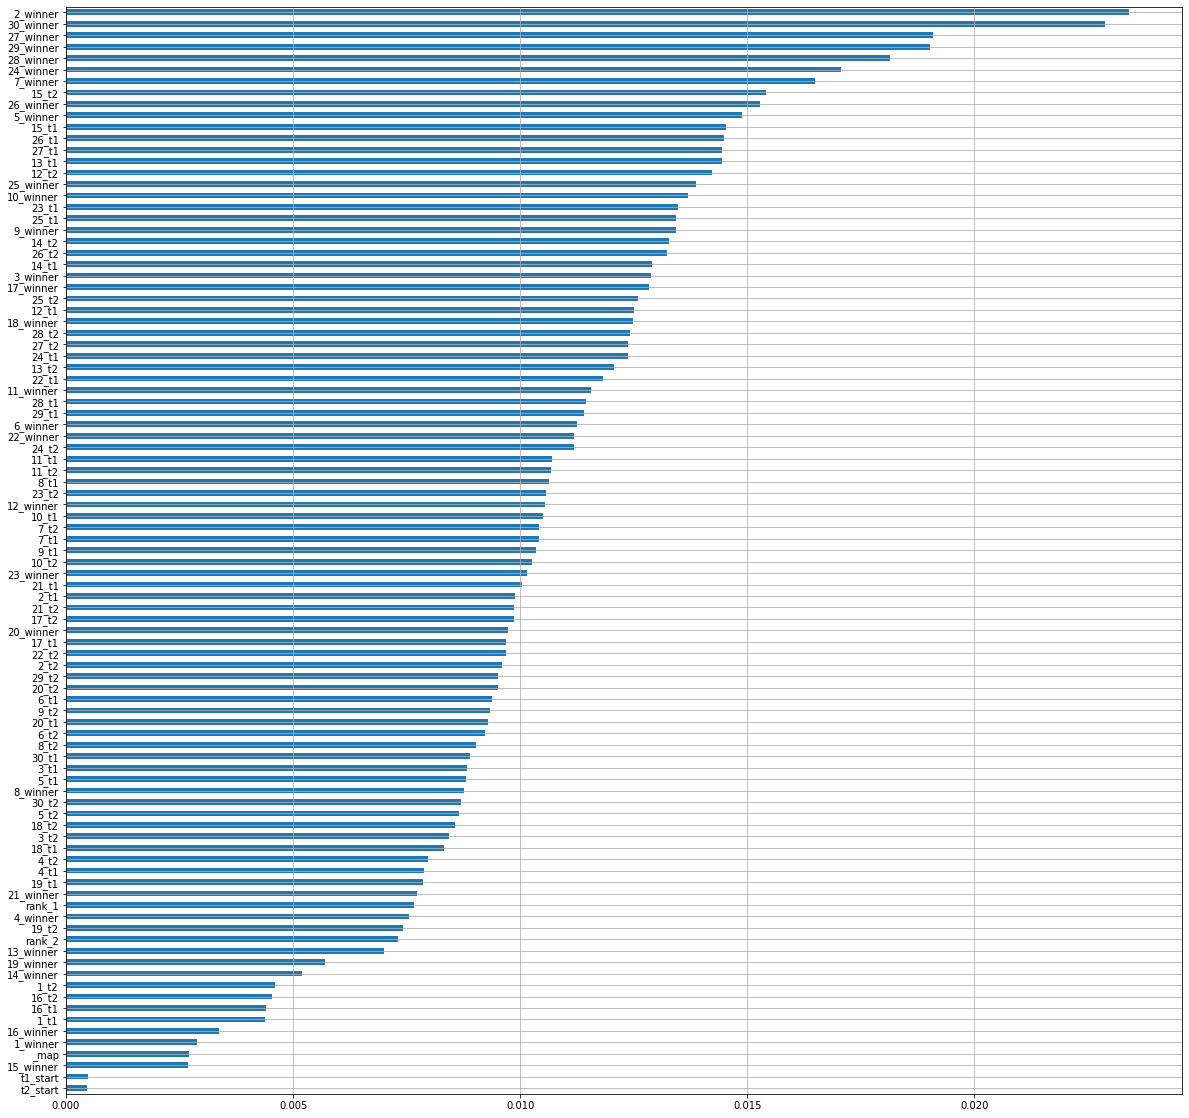

In [136]:
# важность признаков

# for idx, batch in enumerate(batches):
plot_features_scores(model=rf, data=X, target=y,
                     column_names=X.columns, model_type='rf',
                     ) #batch_size=batch_size, batch_pos=idx*5

In [137]:
selector = GenericUnivariateSelect(score_func=mutual_info_classif, 
                                   mode='k_best', 
                                   param=6)
# применим к нашему датасету
selector.fit(X, y)
# метод transform вернёт массив с отобранными признаками
# выведем результаты оценки каждого признака 
pd.DataFrame(data={'score':selector.scores_,
                   'support':selector.get_support()}, 
             index=X.columns).sort_values(by='score',ascending=False)

,score,support
12_winner,0.041283,True
15_t2,0.040192,True
12_t2,0.039714,True
14_t1,0.039536,True
5_winner,0.038936,True
...,...,...
16_t2,0.001978,False
_map,0.000355,False
30_t1,0.000278,False
16_t1,0.000000,False


In [147]:
sd = pd.DataFrame(data={'score':selector.scores_,
                   'support':selector.get_support()}, 
             index=X.columns).sort_values(by='score',ascending=False)
sd[sd['support'] == True]

AttributeError: 'tuple' object has no attribute 'scores_'

In [142]:
# добавим селектор в пайплайн к случайному лесу
selector = ('selector', GenericUnivariateSelect(score_func=mutual_info_classif, 
                                                mode='k_best'))
rf.steps.insert(0, selector)


In [146]:
# grid search
rf_params = {'selector__param': np.arange(7,8),
             'rf__max_depth': np.arange(5, 7, 2),
             'rf__max_features': np.arange(0.3, 0.5, 0.2)}
print('grid search results for rf')
rf_grid = grid_search(model=rf, gs_params=rf_params)

grid search results for rf
scores = [0.7631063270899956, 0.7737153380539059, 0.7715919801216691, 0.8025423128552251, 0.7598726758632508], 
mean score = 0.77417 +/- 0.01509            
best params = {'rf__max_depth': 5, 'rf__max_features': 0.3, 'selector__param': 7}


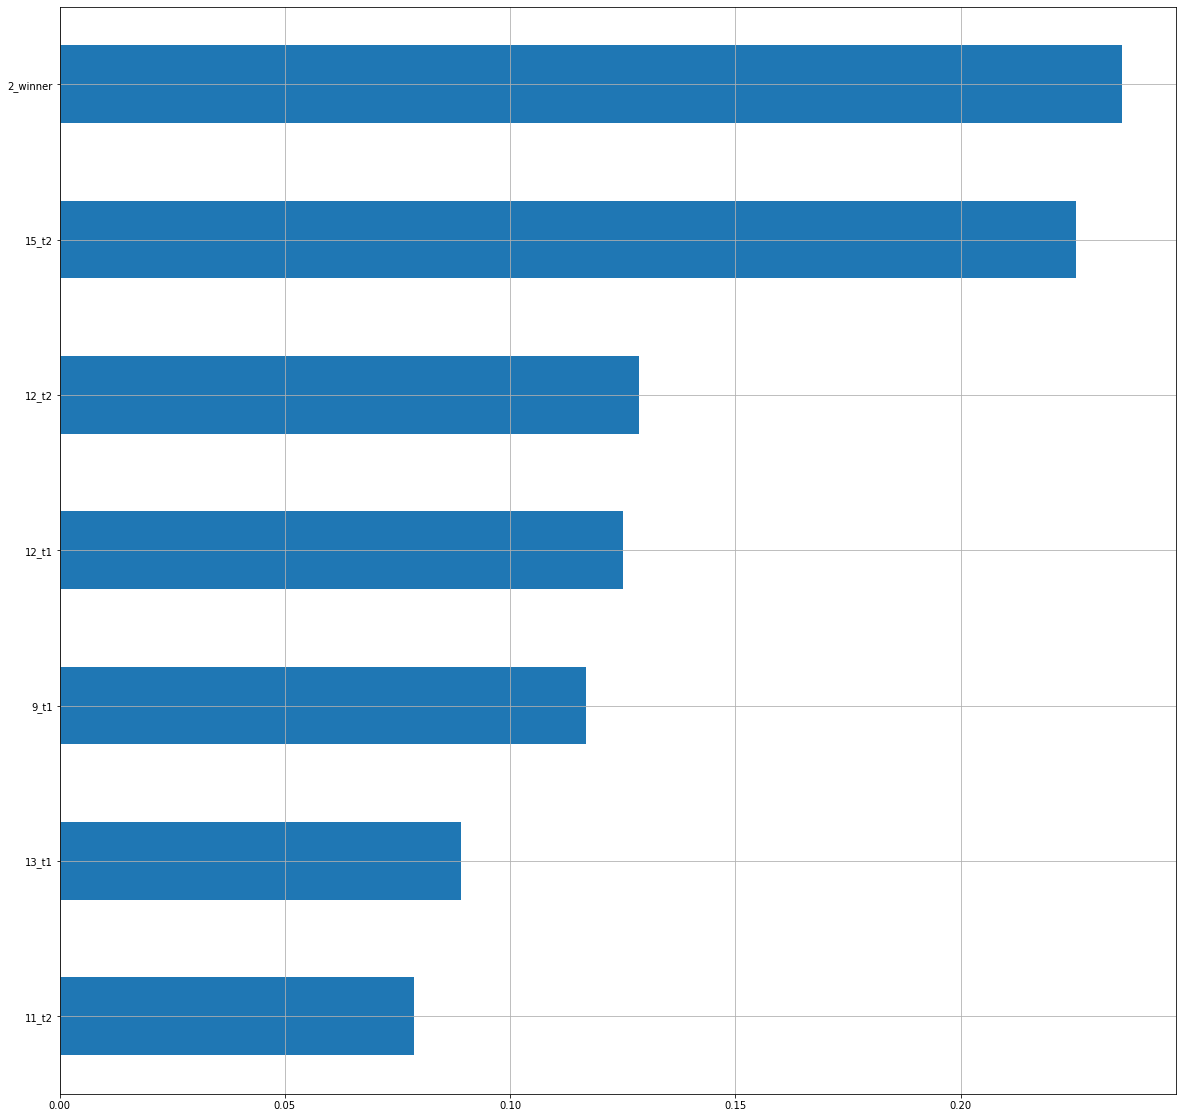

In [148]:
# выведем признаки, отобранные селектором
selected_features = [X.columns[i] for i, support
                     in enumerate(rf_grid.best_estimator_['selector'].get_support()) if support]

plot_features_scores(model=rf_grid.best_estimator_, 
                     data=X, target=y, column_names=selected_features, model_type='rf')
# Таким образом были выявлены наиболее важные парметры для обучения модели по прогнозу в live-режиме
# 1) Победитель второго раунда (сразу после пистолетного, 
# он важен так как команды имеют несколько вариантов развития событий в этот момент)
# 2) Победитель пятнадцатого раунда (завершающего первую половину игры)
# 3) Промежуточные раунды в основном в первой половине игры